In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from sklearn.metrics import auc
from statistics import mean
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score


In [2]:
def calculate_auc_avg(tickers, predictions, true_values):
    predictions = predictions.sort_values(by='fecha')
    true_values = true_values.sort_values(by='fecha')
    
    
    # renombro las columnas
    column_names = {}
    for column in predictions.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_pred'
    
    predictions = predictions.rename(columns=column_names)
    
    column_names = {}
    for column in true_values.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_true'
    
    true_values = true_values.rename(columns=column_names)
    performance = pd.concat(
        [
            predictions,
            true_values
        ], axis=1, join="inner"
    )
    
    auc_list = []
    for ticker in tickers:
        y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
        y_pred = performance[performance[f'{ticker}_pred'].notna()][f'{ticker}_pred']
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        auc_list.append(precision)

    return mean(auc_list)

In [3]:
def max_drawdown(serie):
    max_valor_acumulado = serie[0]
    max_dd = 0

    for valor_actual in serie[1:]:
        if valor_actual > max_valor_acumulado:
            max_valor_acumulado = valor_actual
        else:
            dd = (max_valor_acumulado - valor_actual) / max_valor_acumulado
            if dd > max_dd:
                max_dd = dd

    return max_dd

In [4]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)

tickers = config["tickers"] 
tickers

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF']

In [5]:
os.listdir('./backbone/data/backtest/experiments')

['Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_1-UseDaysClose_True',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_2-UseDaysClose_False',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_3-UseDaysClose_False',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_3-UseDaysClose_True',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_2-UseDaysClose_False',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_False',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_True',
 'Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-Tradi

In [6]:
results_dict = {}

for path in os.listdir('./backbone/data/backtest/experiments'):
    if not path.endswith('.csv') and path.startswith('Mode_train'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

            final_wallet_value = wallet.tail(1).iloc[0]['wallet']
            initial_wallet_value = 1000
            results_dict[path]['wallet'] = ((final_wallet_value - initial_wallet_value) / initial_wallet_value) * 100
            results_dict[path]['max_drawdown'] = max_drawdown(wallet['wallet'])
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_time'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_time'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] >= 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] < 0].shape[0]
    
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 
    
            results_dict[path]['sharpe_ratio'] = (orders['profit'].mean() - 0.04) / orders['profit'].std()
        
            results_dict[path]['winning_rate'] = orders[orders['profit'] >= 0]['profit'].mean() / (-1 * orders[orders['profit'] < 0]['profit'].mean())
            
            results_dict[path]['recover_factor'] = orders[orders['profit'] >= 0]['profit'].sum() / (-1 * orders[orders['profit'] < 0]['profit'].sum())

            results_dict[path]['stability_index'] = orders['profit'].std() / orders['profit'].mean()

            for ticker in tickers:
                results_dict[path][f'profits_in_{ticker}'] = orders[orders['ticker'] == ticker]['profit'].sum()

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0
        # try:
        # train_results = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'trainres.csv'))
        # avg_train_auc = train_results['precision'].mean()
        # results_dict[path]['avg_train_precision'] = avg_train_auc
        # # except:
        # #     results_dict[path]['avg_train_auc'] = 0
            
        # # try:
        # stock_predictions = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'preds.csv'))
        # true_values = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'truevals.csv'))

        # avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
        # results_dict[path]['avg_test_auc'] = avg_auc_score
        # except:
        #     results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')

Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_1-UseDaysClose_True
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_2-UseDaysClose_False
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_3-UseDaysClose_False
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_10-RR_3-UseDaysClose_True
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_2-UseDaysClose_False
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_False
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_True
Mode_train-Model_gradient_boosting-TrainWw_120-TrainPd_24-TradingStgy_bband_strategy-PeriodsF

In [7]:
beta = 0.05
eurusd = pd.read_csv('./backbone/data/backtest/symbols/EURUSD.csv')
results['buy_ratio'] = results['buys'] / (eurusd.Date.nunique() * len(tickers))
results['operation_ratio_2'] = ((1 + beta**2) * results['operation_ratio'] * results['buy_ratio']) / (beta * results['operation_ratio'] + results['buy_ratio'])

In [8]:
results.columns

Index(['wallet', 'max_drawdown', 'buys', 'sells', 'avg_incomes',
       'good_operations', 'bad_operations', 'operation_ratio', 'sharpe_ratio',
       'winning_rate', 'recover_factor', 'stability_index',
       'profits_in_EURUSD', 'profits_in_GBPUSD', 'profits_in_USDJPY',
       'profits_in_USDCAD', 'profits_in_AUDUSD', 'profits_in_USDCHF',
       'buy_ratio', 'operation_ratio_2'],
      dtype='object')

In [9]:
results = results[
    [
        'operation_ratio_2',
        'operation_ratio', 
        'buy_ratio',
        'winning_rate',
        'recover_factor',
        'sharpe_ratio',
        'stability_index',
        'max_drawdown',
        'good_operations',
        'bad_operations',
        'wallet',
        'profits_in_EURUSD',
        'profits_in_GBPUSD', 
        'profits_in_USDJPY', 
        'profits_in_USDCAD',
        'profits_in_AUDUSD', 
        'profits_in_USDCHF',
        # 'avg_train_precision',
        # 'avg_test_auc',
    ]
].sort_values(by=['wallet'], ascending=[False])

positive_results = results[
    (results['wallet']>40)
    & (results['max_drawdown']<=0.25)
]

positive_results

,operation_ratio_2,operation_ratio,buy_ratio,winning_rate,recover_factor,sharpe_ratio,stability_index,max_drawdown,good_operations,bad_operations,wallet,profits_in_EURUSD,profits_in_GBPUSD,profits_in_USDJPY,profits_in_USDCAD,profits_in_AUDUSD,profits_in_USDCHF
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_5-UseDaysClose_False,0.160084,0.392193,0.013468,2.397080,1.546740,0.144429,6.848288,0.146858,211,327,197.298672,131.08122,623.85019,156.071,205.40375,379.72253,476.85803
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_4-UseDaysClose_False,0.163998,0.371575,0.014613,2.404873,1.421955,0.123307,8.003554,0.144868,217,367,178.259106,56.38405,661.96849,-12.048,182.44835,387.60365,506.23452
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_20-RR_4-UseDaysClose_False,0.160447,0.393321,0.013493,2.298960,1.490457,0.138628,7.120562,0.140778,212,327,167.284489,74.29934,537.38411,61.487,174.47376,375.79867,449.40201
Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_False,0.157212,0.381308,0.013318,2.195826,1.353319,0.113391,8.659306,0.206451,204,331,118.145262,144.17263,401.55627,7.250,138.90795,147.90212,341.66365
Mode_train-Model_gradient_boosting-TrainWw_480-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_5-SL_10-RR_2-UseDaysClose_False,0.151285,0.379722,0.012522,1.877418,1.149317,0.059846,16.035108,0.160513,191,312,49.843235,73.75224,53.20849,71.515,-228.51499,344.96463,183.50698
Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False,0.139495,0.347639,0.011601,2.164452,1.153425,0.054852,17.532074,0.158819,162,304,48.631274,159.26185,-145.95939,188.903,-1.43924,-28.50900,314.05552
Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_False,0.143846,0.359081,0.011949,2.117046,1.186097,0.064043,14.999232,0.205213,172,307,48.622734,-93.39315,120.00132,81.226,148.23732,143.22828,86.92757
Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_3-SL_15-RR_3-UseDaysClose_False,0.143672,0.338677,0.012422,2.284002,1.169686,0.058777,16.248407,0.240155,169,330,44.381369,-24.93204,98.22541,94.052,161.51957,154.70523,-39.75648


In [10]:
columns = [
    'profits_in_EURUSD',
    'profits_in_GBPUSD', 
    'profits_in_USDJPY', 
    'profits_in_USDCAD',
    'profits_in_AUDUSD', 
    'profits_in_USDCHF'
]

for column in columns:
    print(column, positive_results[column].mean(), positive_results[column].std())

profits_in_EURUSD 65.07826749999171 86.9595605079575
profits_in_GBPUSD 293.77936124998666 301.2245937383135
profits_in_USDJPY 81.0569999999925 67.63009414244837
profits_in_USDCAD 97.6295587499838 146.01683518394714
profits_in_AUDUSD 238.17701375002113 154.90114596061298
profits_in_USDCHF 289.8614750000156 196.99472447771606


In [11]:
# results.loc[
#     [
#         'train_gradient_boosting_train_window_38_train_period_1_trading_strategy_strategies.bband_strategy',
#         'train_gradient_boosting_train_window_38_train_period_1_trading_strategy_strategies.macd_strategy',
#         'train_gradient_boosting_train_window_461_train_period_1_trading_strategy_strategies.bband_strategy',
#         'train_gradient_boosting_train_window_461_train_period_1_trading_strategy_strategies.macd_strategy',
#         'train_logistic_regression_train_window_38_train_period_1_trading_strategy_strategies.bband_strategy'
#     ]
# ]

In [12]:
filter_results = results[results['wallet']>0]
filter_results.shape

(123, 17)

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_3-SL_15-RR_3-UseDaysClose_False


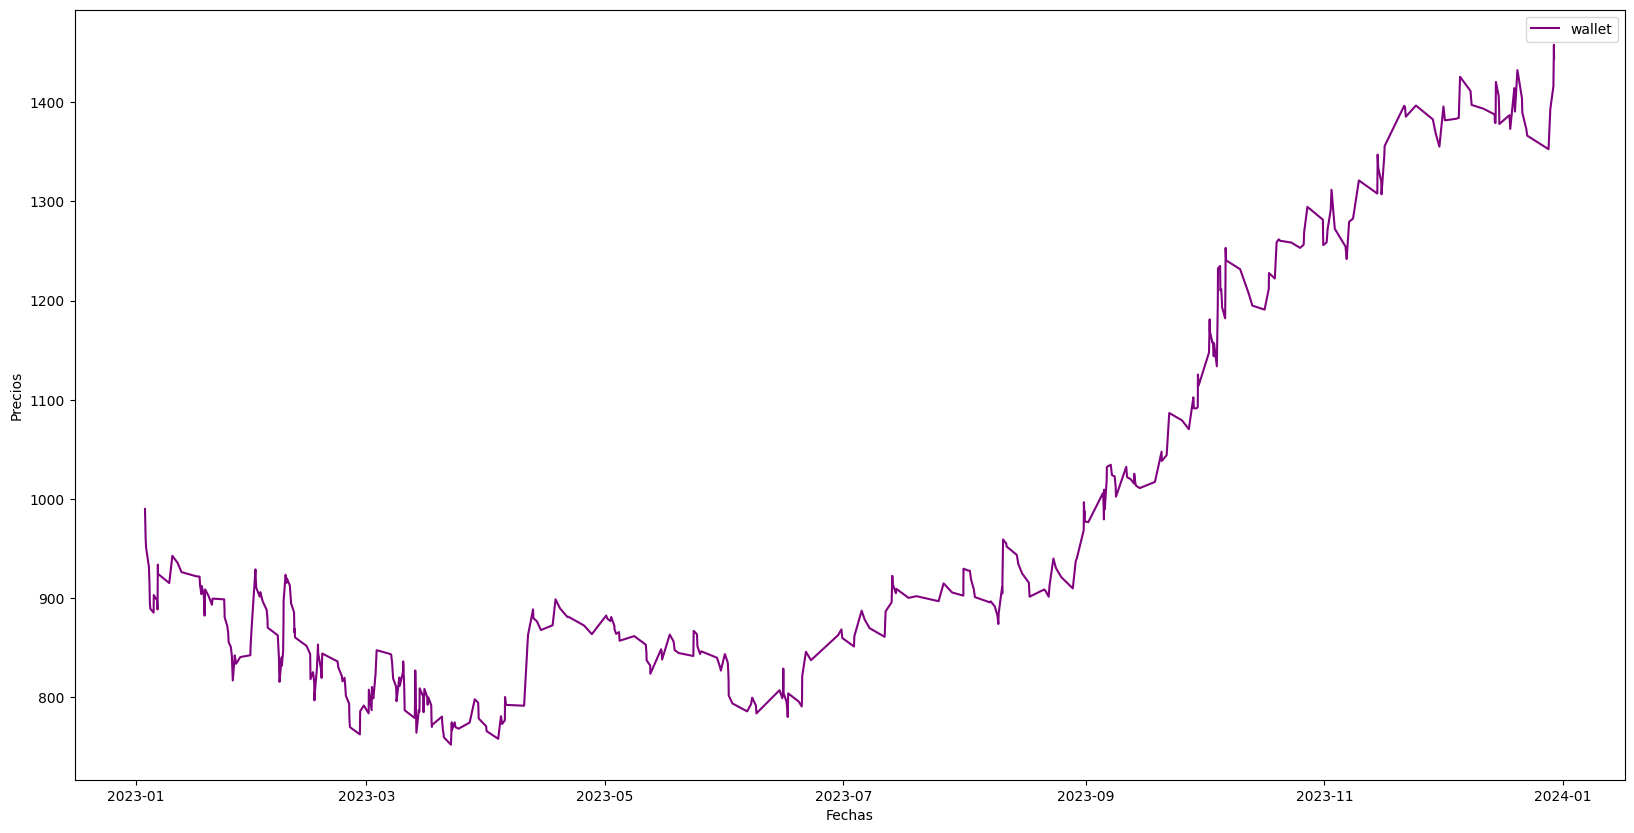

In [13]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

filter_results = positive_results
for path in filter_results.index:

    wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

    # Datos de ejemplo
    x_wallet = pd.to_datetime(wallet['date'])
    y_wallet = wallet['wallet']  # Datos para la línea
    
    # Crear una figura y ejes
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Agregar la línea
    ax.plot(x_wallet, y_wallet, label='wallet', color='purple')
    
    # Etiquetas de los ejes y leyenda
    ax.set_xlabel('Fechas')
    ax.set_ylabel('Precios')
    ax.legend()
    
    # Mostrar el gráfico
    print(path)
    plt.show()
    time.sleep(5)
    clear_output(wait=True)

Mode_train-Model_gradient_boosting-TrainWw_480-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_5-SL_10-RR_2-UseDaysClose_False
Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False
Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_3-SL_10-RR_3-UseDaysClose_False
Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_bband_strategy-PeriodsFwTg_10-SL_15-RR_3-UseDaysClose_True


In [14]:
import re

In [15]:
filter_results = filter_results.reset_index().rename(columns={'index':'experiment'})

In [16]:
filter_results['model'] = filter_results['experiment'].apply(lambda x: re.search(r'-Model_(.*?)-', x).group(1))


In [17]:
filter_results['window'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainWw_(.*?)-', x).group(1))
filter_results['train_period'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainPd_(.*?)-', x).group(1))
filter_results['strategy'] = filter_results['experiment'].apply(lambda x: re.search(r'-TradingStgy_(.*?)-', x).group(1))
filter_results['periods_forward_target'] = filter_results['experiment'].apply(lambda x: re.search(r'-PeriodsFwTg_(.*?)-', x).group(1))
filter_results['sl'] = filter_results['experiment'].apply(lambda x: re.search(r'-SL_(.*?)-', x).group(1))
filter_results['rr'] = filter_results['experiment'].apply(lambda x: re.search(r'-RR_(.*?)-', x).group(1))
filter_results['use_days_to_close'] = filter_results['experiment'].apply(lambda x: x.split('UseDaysClose_')[1])

In [18]:
gb = filter_results.groupby(
    by=['strategy', 'model', 'window', 'rr', 'periods_forward_target']
).agg(
    {
        'max_drawdown':['mean', 'std']
    }
)


gb.sort_values(by=('max_drawdown', 'mean'), ascending=False).dropna().round(4)

max_drawdown  \
                                                                          mean   
strategy       model             window rr periods_forward_target                
bband_strategy gradient_boosting 960    4  10                           0.1428   

                                                                           
                                                                      std  
strategy       model             window rr periods_forward_target          
bband_strategy gradient_boosting 960    4  10                      0.0029

In [19]:
gb = filter_results.groupby(
    by=['rr']
).agg(
    {
        'winning_rate':['mean', 'std']
    }
)


gb

winning_rate          
           mean       std
rr                       
2      1.877418       NaN
3      2.190332  0.070344
4      2.351916  0.074892
5      2.397080       NaN

In [20]:
gb = filter_results.groupby(
    by=['window']
).agg(
    {
        'winning_rate':['mean', 'std']
    }
)


gb.sort_values(by=('winning_rate', 'mean'))

winning_rate          
               mean       std
window                       
480        1.877418       NaN
1440       2.200524  0.118056
960        2.292238  0.111072

In [21]:
gb = filter_results.groupby(
    by=['periods_forward_target']
).agg(
    {
        'winning_rate':['mean', 'std']
    }
)


gb.sort_values(by=('winning_rate', 'mean'))

winning_rate          
                               mean       std
periods_forward_target                       
5                          2.020935  0.202964
10                         2.282757  0.125759
3                          2.284002       NaN

In [22]:
0/0

ZeroDivisionError: division by zero

In [ ]:
results_dict = {}

for path in os.listdir('./data'):
    if not path.endswith('.csv') and path.startswith('test_'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
            results_dict[path]['wallet'] = wallet.tail(1).iloc[0]['wallet']
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_date'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_date'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] > 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] <= 0].shape[0]
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0

        try:
            train_results = pd.read_csv(os.path.join('./data', path, 'train_results.csv'))
            avg_train_auc = train_results['auc'].mean()
            results_dict[path]['avg_train_auc'] = avg_train_auc
        except:
            results_dict[path]['avg_train_auc'] = 0
            
        try:
            stock_predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))
            true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))

            avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
            results_dict[path]['avg_test_auc'] = avg_auc_score
        except:
            results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')


Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False







Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False